In [130]:
using Pkg; Pkg.add("BandedMatrices"); Pkg.add("LinearAlgebra"); Pkg.add("Plots")
using BandedMatrices;
using LinearAlgebra;
using Plots;

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [131]:
Δx = 0.1; c = 1; Δt1 = 0.1; # Courant number is 1
k1 = c*Δt1/(12*Δx);
k2 = c*Δt1/(2*Δx);
x = -6:Δx:6;
tfinal = 2;
time = 0:Δt1:tfinal;
u = zeros(length(x),length(time));

In [132]:
u0 = zeros(length(x));
for i in 1:length(x)
    u0[i] = exp(-x[i]^2)
end
u[:,1] = u0;

In [133]:
u

121×21 Array{Float64,2}:
 2.31952e-16  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 7.62446e-16  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.4566e-15   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 7.7584e-15   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.40173e-14  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 7.28772e-14  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.16757e-13  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.31929e-13  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.80583e-12  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 5.05825e-12  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.38879e-11  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.73757e-11  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 9.85951e-11  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0

## Define the Matrix

In [134]:
function systemMatrix(k1,k2,n)
    A = BandedMatrix(Eye(n),(2,2));
    A[band(-2)]=k1*ones(length(A[band(-2)])); # fill in the values for sub-diagonal 2
    A[band(-1)]=-8*k1*ones(length(A[band(-1)])); # fill in the values for sub-diagonal 1

    A[band(1)]=8*k1*ones(length(A[band(1)])); # fill in the values for super-diagonal 1
    A[band(2)]=-k1*ones(length(A[band(2)])); # fill in the values for super-diagonal 2

    AA = Matrix(A); # Convert to regular matrix type instead of banded matrix

    # For the first row, Dirichlet boundary condition
    AA[1,2]=0; AA[1,3]=0;

    # For the second and second-to-last rows, implement second-order central difference
    AA[2,1]= -k2; AA[2,3] = k2; AA[2,4] = 0;
    AA[end-1,end] = k2; AA[end-1,end-2]=-k2; AA[end-1,end-3] = 0;

    # For the last row, implement von Neumann boundary condition
    AA[end,end-1]=-1; AA[end,end-2] = 0;

    A= BandedMatrix(AA,(2,2)) # Convert back to banded matrix
    return A;
end

systemMatrix (generic function with 1 method)

In [137]:
rhs = u0;
A1 = systemMatrix(k1,k2,121);
for j in 2:length(time)
    # at each time instant, solve a linear system to find the next step.
    u[:,j] = A1\rhs;
    rhs = u[:,j];
end

## Re-calculate everything for different Courant number

In [138]:
Δt2 = 0.5; # Courant number is 1
k1_new = c*Δt2/(12*Δx);
k2_new = c*Δt2/(2*Δx);
x = -6:Δx:6;
tfinal = 2;
time = 0:Δt1:tfinal;
u2 = zeros(length(x),length(time));
u2[:,1] = u0;
rhs = u0;
A2 = systemMatrix(k1_new,k2_new,121);
for j in 2:length(time)
    # at each time instant, solve a linear system to find the next step.
    u2[:,j] = A2\rhs;
    rhs = u2[:,j];
end

### Euler implicit in time, 4th-order central difference in space

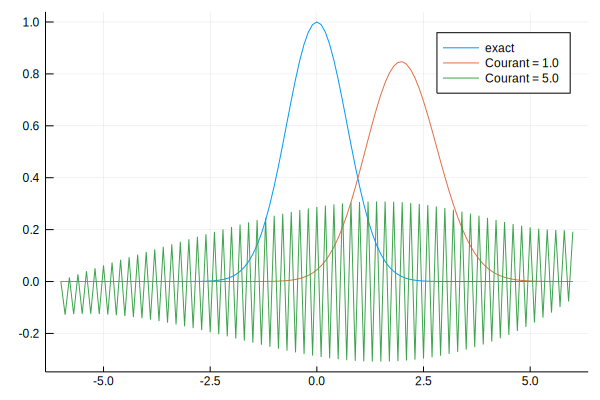

In [143]:
plot(x,hcat(u[:,1],u[:,end],u2[:,end]),label=["exact" "Courant = 1.0" "Courant = 5.0"])

We can investigate how the Courant = 5.0 case got this bad. Let's look at the time evolution of the wave:

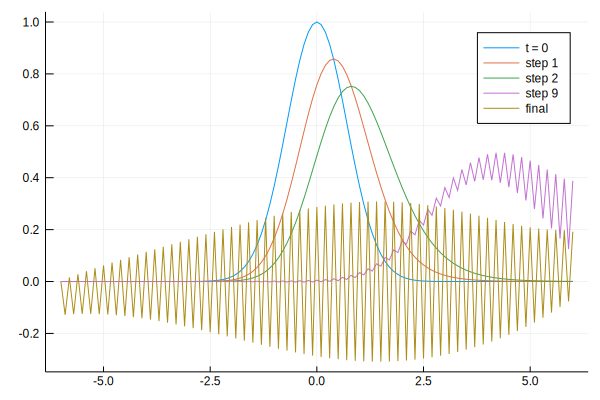

In [161]:
plot(x,hcat(u2[:,1],u2[:,2],u2[:,3],u2[:,10],u2[:,end]),label=["t = 0" "step 1" "step 2" "step 9" "final"])